In [1]:
import pandas as pd
from collections import defaultdict

# Using COSMIC

In [2]:
# path to intogen stats file
stats_cohort = '/workspace/projects/intogen_2017/pipeline/datasets/hg38_vep92_develop/stats_cohorts/stats_cohorts.tsv'

df_stats = pd.read_csv(stats_cohort, sep ='\t')

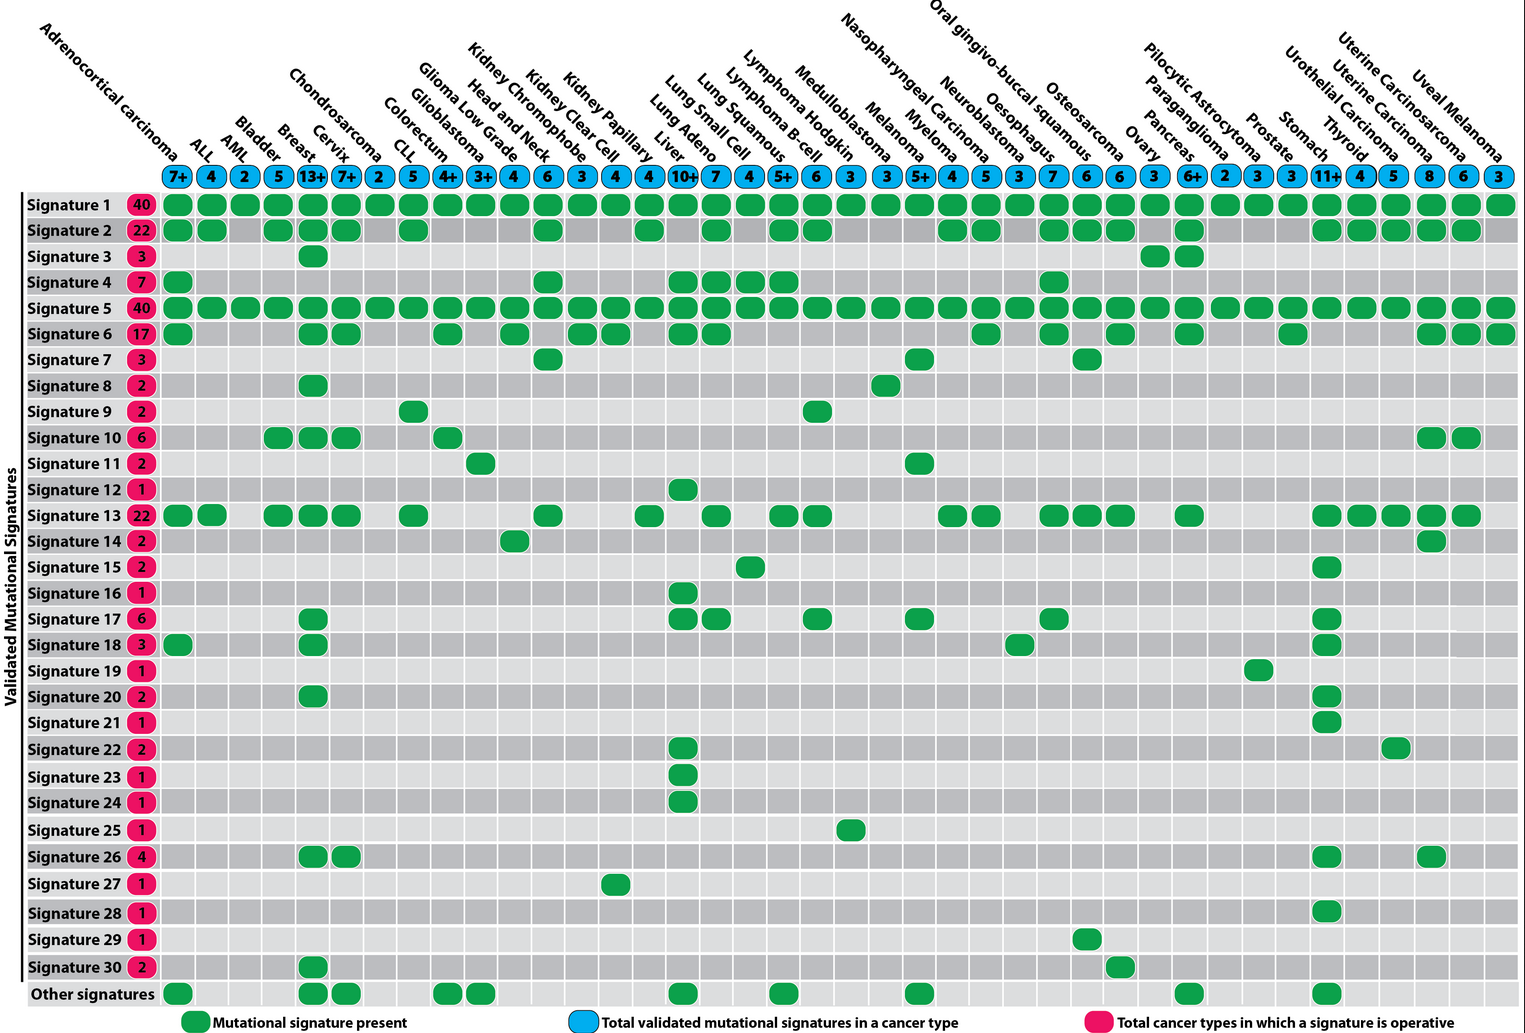

In [3]:
# add only allowed signatures

sigs_equivalent = {'ACC':[1,2,4,5,6,13,18],
'ALL':[1,2,5,13], 
'AML':[1,5], 
'BLCA':[1,2,5,10,13], #not found
'BRCA':[1,2,3,5,6,8,10,13,17,18, 20, 26,30], 
'CESC':[1,2,5,6,10,13,26],
'CH': [1,5], 
'CLL':[1,2,5,9,13], 
'COREAD':[1,5,6,10], 
 
'GBM':[1,5,6,11,13], 
'LGG':[1,5,6,14],
'NERVOUS_SYSTEM_CANCER':[1,5,6,11,13],
 
'HNSC':[1,2,4,5,7,13],
'RCH':[1,5,6], 
'RCCC':[1,5,6],
'RPC':[1,2,5,13],
'HC':[1, 4,5,6,12,16,17,22,23,24], 
'LUAD':[1,2,4,5,6,13,17], 
 'LUNG_CANCER':[1,2,4,5,6,13,17], 
'SCLC':[1,4,5,15], 
'LUSC':[1,2,4,5,13], 
'DLBCL':[1,2,5,9 ,13,17], 

# added
'LY': [1,2,5,9,13,17],
'NHLY':[1,2,5,9,13,17],
 
'MB':[1, 2,8], 
'CM':[1,5,7,11,17], 
'MM':[1,2,5,13], 
'NSPH':[1,2,5,6,13], 
'NB':[1, 5, 18], 
'ESCA':[1, 2, 4, 5,6, 13, 17], 
'OS':[1,2,5,6, 13, 30], 
'OV':[1,3,5], 
'PAAD':[1,2,3,5,6,13, ], 
'PIA':[],
'PRAD':[1,5,6], 
'ST':[1,2,5, 13,15, 17,18, 20, 21, 26, 28], 
'THCA':[1,2,5,13], 
'UCEC':[1,2,5,6,10,13,14, 26], 
'UVM':[1,5,6]
}

In [4]:
matrix_d = defaultdict(lambda : defaultdict(int))

for i, row in df_stats.iterrows():
    if row['cancer_type'] in sigs_equivalent:
        for signature in sigs_equivalent[row['cancer_type']]:
            matrix_d[row['COHORT']]['Signature.{}'.format(signature)] = 1
            
dataframe_signatures_allowed = pd.DataFrame(matrix_d).fillna(0).T

# save allowed exposures
dataframe_signatures_allowed.to_csv('exposures_ttype_intogen.cosmic.tsv', 
                                   sep ='\t')

# PCAWG

In [3]:
# get the PCAWG cohorts and its real name
pcawg_ttypes = df_stats[df_stats['source']=='PCAWG']
pcawg_ttypes['REAL_NAME'] = pcawg_ttypes['COHORT'].apply(lambda x : x.split('PCAWG_WGS_')[1])

/home/opich/anaconda3/envs/period/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
dic_pcawg_2_cancertype = dict(zip(pcawg_ttypes.REAL_NAME, pcawg_ttypes.cancer_type))

In [5]:
# get the matrix of exposures in PCAWG
df = pd.read_csv('/workspace/projects/intogen_2017/test/signature_fitting/data/PCAWG_sigProfiler_SBS_signatures_in_samples.csv', 
               sep =',')
df.drop(['Sample Names', 'Accuracy'], axis = 1 , inplace = True)

all_cancer_types = df['Cancer Types'].drop_duplicates().tolist()

In [6]:
all_cancer_types.remove('Bone-Benign')
all_cancer_types.remove('Bone-Epith')
all_cancer_types.remove('Breast-DCIS')
all_cancer_types.remove('Cervix-AdenoCA')
all_cancer_types.remove('SoftTissue-Liposarc')
all_cancer_types.remove('Myeloid-MDS')

In [7]:
sigs_active_ttype = defaultdict(list)
dic_equi = {'SoftTissue-Leiomyo':'BONE_LEIOMYO'}
all_sigs = []

for ttype in all_cancer_types:
    
    data = df[df['Cancer Types']==ttype]
    ttype = dic_equi.get(ttype, ttype)
    data.drop(['Cancer Types'], axis = 1, inplace = True)
    all_sigs = data.columns.tolist()
    sigs_active = data.sum()[data.sum()>0].index.tolist()
    sigs_active_ttype[dic_pcawg_2_cancertype[ttype.upper().replace('-', '_')]].extend(sigs_active)
    

/home/opich/anaconda3/envs/period/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
sigs_active_ttype['SMALL_INTESTINE_CANCER'] = sigs_active_ttype['COREAD']
sigs_active_ttype['NERVOUS_SYSTEM_CANCER'] = sigs_active_ttype['GBM'] + sigs_active_ttype['LGG']
sigs_active_ttype['LUNG_CANCER'] = sigs_active_ttype['LUAD'] + sigs_active_ttype['LUSC']


In [9]:
all_ttypes_intogen = df_stats['cancer_type'].drop_duplicates().tolist()
matrix_d = defaultdict(lambda : defaultdict(int))

for sig in set(all_sigs):
    for ttype in all_ttypes_intogen:
        if ttype in sigs_active_ttype:
            if sig in sigs_active_ttype[ttype]:
                sig_wanted = 1
            else:
                sig_wanted = 0
        else:
            sig_wanted = 1
        
        matrix_d[sig][ttype]= sig_wanted
        
signatures_allowed = pd.DataFrame(matrix_d)

signatures_allowed.to_csv('exposures_ttype_intogen.pcawg.tsv', 
                         sep ='\t', index = True, header = True)